# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {Vinzenz Brehme, Dennis Exter, Miriam Reichlmaier}  
Summer Term 2024  

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Perceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

!pip install torchsummary
import torchsummary


torch.manual_seed(42) # Set manual seed

  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [3]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
# Mean and Std of Training-Set
data = train_dataset.data / 255
mean = data.mean(axis=(0,1,2))
std = data.std(axis=(0,1,2))
print(f"mean = {mean}")
print(f"std = {std}")

Files already downloaded and verified
Files already downloaded and verified
mean = [0.49139968 0.48215841 0.44653091]
std = [0.24703223 0.24348513 0.26158784]


In [5]:
from torch.utils.data import DataLoader
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
generator = torch.Generator()

cifar10_train, cifar10_val = torch.utils.data.random_split(dataset=train_dataset, lengths=[0.9,0.1], generator=generator)

test_loader  = DataLoader(test_dataset,  batch_size=batch_size)
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(cifar10_val,   batch_size=batch_size)

In [6]:
## TODO: plot images with their labels after augmentations
import math
def show_batch(dl):
    f,l = next(iter(dl))
    print(f.shape)
    print(l.shape)
    classes = ["airplane", "automobile", "bird", "cat" , "deer", "dog", "frog", "horse", "ship", "truck"]
    scale_factor = 1.5
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    axes = axes.flatten()

    for i, (images, labels) in enumerate(dl):
        for img, label in zip(images, labels):
            ax = axes[i]
            ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Transponiere die Dimensionen (C, H, W) -> (H, W, C)
            ax.set_title(f"Label: {classes[label.item()]}", fontsize=8)
            ax.axis('off')
            i += 1
            if i >= 100:
                break
        if i >= 100:
            break

    plt.tight_layout()
    plt.show()



torch.Size([256, 3, 32, 32])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

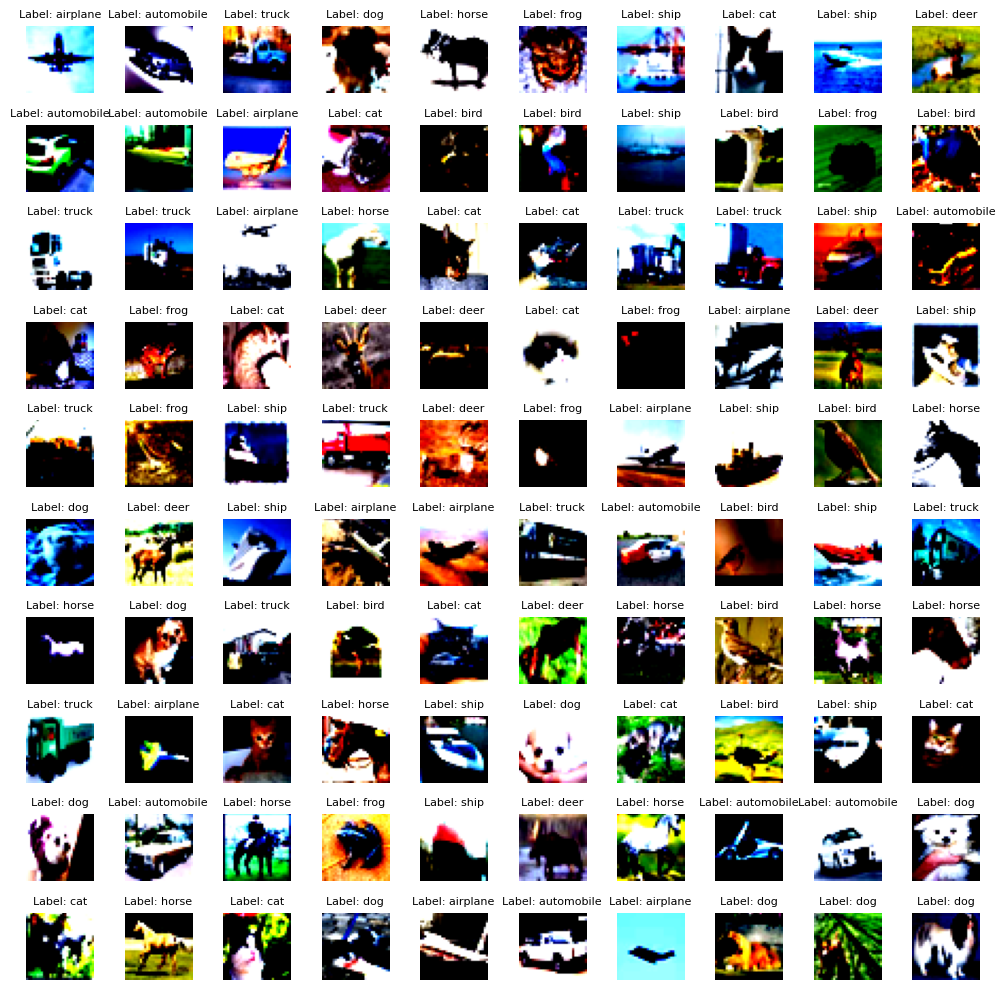

In [7]:
show_batch(train_loader)

In [8]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [9]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct / total
    return ratio

In [10]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 
from tqdm import tqdm

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    # TODO: refine the training function from above
    # it should contain:
    # - saving of losses
    # - calculation of accuracy
    # - returning the mean loss and accuracy
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0 
    for x_batch, target in dataloader:
        x_batch = x_batch.to(device)
        target = target.unsqueeze(1)[:,0].to(device)
        pred = model(x_batch)
        loss = loss_fn(pred, target)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(pred.data, 1) 
        train_total += target.size(0)        
        train_correct += (predicted == target).sum().item() 

    train_loss = sum(train_losses)/len(dataloader)
    train_acc = accuracy(train_correct, train_total)
    return train_loss, train_acc        
  
def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    model.eval()
    val_losses = []
    val_total = 0
    val_correct = 0
    for x_batch, target in dataloader:
        x_batch = x_batch.to(device)
        target = target.unsqueeze(1)[:,0].to(device)
        pred = model(x_batch)
        loss = loss_fn(pred, target)
        val_losses.append(loss.item())
        _, predicted = torch.max(pred.data, 1)
        val_total += target.size(0)
        val_correct += (predicted == target).sum().item() 

    val_loss = sum(val_losses)/len(dataloader)
    val_acc = accuracy(val_correct, val_total)
    return val_loss, val_acc

In [11]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange

def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

    # TODO: implement master_bar
    master_bar = None

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for _ in trange(num_epochs, desc="Train epoch:"):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        train_losses.append(train_loss)
        val_losses.append(val_loss) 
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

In [12]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    all_labels = []
    all_predictions = []
    model.to(device)
    model.eval()
    
    # iterate through dataloader with no gradients
    with torch.no_grad():
        for imgs, labels in dataloader:
            
            imgs, labels = imgs.to(device), labels.to(device)
            pred = model(imgs)
            # calc indices with highest probability
            _, predicted = torch.max(pred, 1)
            # accumulate values for heatmap
            all_predictions.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

    # Konfusionsmatrix erstellen und anzeigen
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction', fontsize=13)
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17)
    plt.show()
    
    # Klassifikationsbericht drucken
    print(classification_report(all_labels, all_predictions))
    
# get sample batches and calculate dimension based of shapes 
imgs, labels = next(iter(test_loader))
input_dim = imgs.shape[1]*imgs.shape[2]*imgs.shape[3]
#input_dim = 32*32*3
print(f"input dim = {input_dim}")
print(f"num_classes = {num_classes}")

input dim = 3072
num_classes = 10


## Logistic Regression   

In [14]:
import torch.optim as optim
# TODO: define logistic regression model class and its necessary functions
class Logistic_Regression(nn.Module):
    
    # Init Function with super type of nn.Module
    # define linear model
    def __init__(self,input_dim, num_classes):
        super(Logistic_Regression, self).__init__()
        self.model = nn.Linear(input_dim, num_classes)
        self.input_dim = input_dim
        self.classes = num_classes
    
    # forwarding in neural network
    def forward(self, x):
        # flatten input for intial layer
        x = x.reshape(-1,32*32*3)
        output = self.model(x)
        # generate probabilities from input
        #output = torch.sigmoid(x)
        return output
# What are the dimensions of your input layer?
# TODO: flatten the input to a suitable size for the initial layer

Logistic_Regression(
  (model): Linear(in_features=3072, out_features=10, bias=True)
)


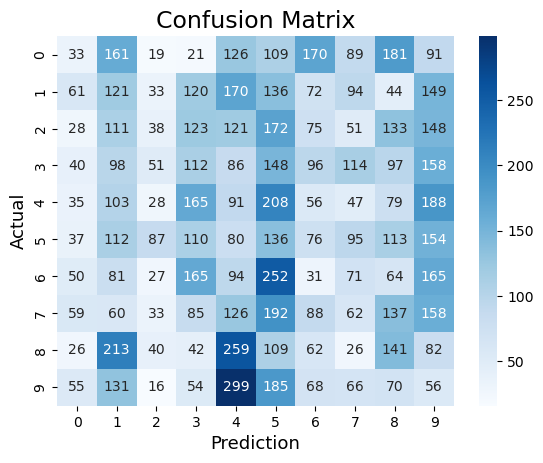

              precision    recall  f1-score   support

           0       0.08      0.03      0.05      1000
           1       0.10      0.12      0.11      1000
           2       0.10      0.04      0.06      1000
           3       0.11      0.11      0.11      1000
           4       0.06      0.09      0.07      1000
           5       0.08      0.14      0.10      1000
           6       0.04      0.03      0.03      1000
           7       0.09      0.06      0.07      1000
           8       0.13      0.14      0.14      1000
           9       0.04      0.06      0.05      1000

    accuracy                           0.08     10000
   macro avg       0.08      0.08      0.08     10000
weighted avg       0.08      0.08      0.08     10000



In [15]:
#define new model and calculate confusion values with function
model = Logistic_Regression(input_dim, num_classes)
print(model)

# Commented this Function because it would'nt compile in given time by kaggle
# Dont know what the mistake is 
calc_confusion_values(test_loader, model, device)

In [35]:
## TODO : Define network, put it to the device and train mode
logistic_regression = Logistic_Regression(input_dim, num_classes)
logistic_regression.to(device)
logistic_regression.train()
#print(f'Model = {logistic_regression}')
#print(f'classes = {num_classes}')


Logistic_Regression(
  (model): Linear(in_features=3072, out_features=10, bias=True)
)

In [36]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [37]:
# TODO: define the loss function
# loss ist schon im model definiert
loss = nn.CrossEntropyLoss()

In [38]:
num_epochs = 20
## TODO: run training over 20 epochs
logre_train_losses, logre_val_losses, logre_train_accs, logre_val_accs = run_training(logistic_regression, optimizer, loss, device, num_epochs, train_loader, val_loader)

Train epoch::  40%|████      | 8/20 [01:59<02:59, 15.00s/it]


KeyboardInterrupt: 

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [88]:
## TODO: Make the 4 layer MLP  with the following shapes :
## input_dim -> 2048 -> 512 -> 128 -> output_dim
## Use RELu as nonlinearity
## In the forward pass do not forget to flatten the input
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_features, output_features): 
        super().__init__()

        self.mlp_classifier = nn.Sequential(
                nn.Linear(in_features=in_features, out_features=2048),
                nn.ReLU(),
                nn.Linear(in_features=2048, out_features=512),
                nn.ReLU(),
                nn.Linear(in_features=512, out_features=128),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=output_features)
            )
        
    def forward(self, x):
            x = torch.flatten(x, 1)
            x = self.mlp_classifier(x)
            return x


In [89]:
## TODO: Define network, put it to device and train mode
mlp_network = MLP(32*32*3, num_classes)

mlp_network.to(device)

mlp_network.train()

MLP(
  (mlp_classifier): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [90]:
## TODO: Define optimizer and loss functions
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_network.parameters(), lr=0.001)

In [91]:
## TODO: Train the MLP over 20 epochs
total_step = len(train_loader)
num_epochs = 20

mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs = run_training(mlp_network, optimizer, loss, device, num_epochs, train_loader, test_loader)
        

Train epoch:: 100%|██████████| 20/20 [12:29<00:00, 37.48s/it]


## Add L2 regularisation

In [33]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.00005 is a good starting point for the regularization strength
# L2 Regularisation is includede in SGD optimizer and can be manipulated by weight_decay
logistic_regression_1 = Logistic_Regression(input_dim, num_classes)
optimizer_1 = torch.optim.Adam(logistic_regression.parameters(), lr=0.001, weight_decay=0.00005)
logistic_regression_1.to(device)


Logistic_Regression(
  (model): Linear(in_features=3072, out_features=10, bias=True)
)

In [34]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs = 20
'''
for i in range(20):
    run_training(logistic_regression_1, optimizer_1, loss, device, num_epochs, train_dataloader, val_dataloader)
'''

'\nfor i in range(20):\n    run_training(logistic_regression_1, optimizer_1, loss, device, num_epochs, train_dataloader, val_dataloader)\n'

## LeNet5

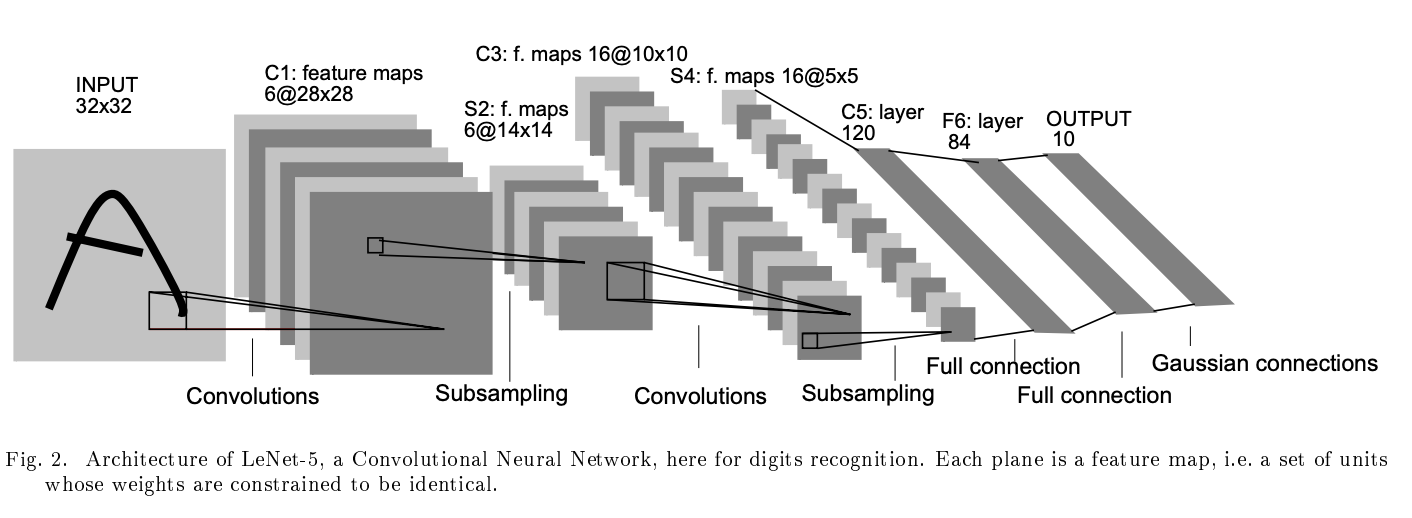

Let's implememt one of the classical convolutional network and apply it for CIFAR-10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implementation of LeNet5 has Tanh as nonlinearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [13]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
## TODO: define network, put it to the device and train mode
network = LeNet5(num_classes, 3)

network.to(device)

network.train()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

For a quick overview of models, torchsummary.summary is quite helpful  
comment: You can also import predefined architectures from `torchvision` and run `torchsummary.summary` on them to get a quick overview

In [15]:
!pip install torchsummary

import torchsummary

In [16]:
## TODO: run torchsummary.summary on the LeNet5 and your MLP model. What do you see?

torchsummary.summary(network, (3, 32, 32))
# torchsummary.summary( TODO: MLP model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [17]:
## TODO: define loss function and optimizer

# Find best learning rate

optimizers = []

for lr in [0.1, 0.01, 0.001, 0.0001]:
    network = LeNet5(num_classes, 3)
    network.to(device)
    network.train()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    optimizers.append(optimizer)

loss_fn = nn.CrossEntropyLoss()

In [21]:
## TODO: train with 20 epochs
num_epochs = 5

for i, optimizer in enumerate(optimizers):
    print(i)
    lenet5_train_losses, lenet5_val_losses, lenet5_train_accs, lenet5_val_accs = run_training(network, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)
    plot_losses(lenet5_train_losses, lenet5_val_losses, num_epochs)


0


Train epoch::   0%|          | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [20]:
num_epochs = 5

network = LeNet5(num_classes, 3)
network.to(device)
network.train()
    
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

lenet5_train_losses, lenet5_val_losses, lenet5_train_accs, lenet5_val_accs = run_training(network, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)


Train epoch:: 100%|██████████| 5/5 [21:11<00:00, 254.28s/it]


## Analysis 

In [21]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

def plot_losses(train_losses, val_losses, epochs, loss, network_name):
    epochs_range = range(epochs)
    label_str = ""
    
    if (loss):
        label_str = "Loss"
    else:
        label_str = "Accuracy"
        
    plt.plot(epochs_range, train_losses, marker="o", color="blue", linestyle="-", label="Train " + label_str) 
    plt.plot(epochs_range, val_losses, marker="o", color="orange", linestyle="-", label="Validation " + label_str)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(label_str)
    plt.xticks(epochs_range)
    plt.title(network_name + ": Epoch vs " + label_str)
    plt.show()

plot_losses(mlp_train_losses, mlp_val_losses, 20, loss=True, network_name="MLP")
plot_losses(lenet5_train_losses, lenet5_val_losses, 30, loss=True, network_name="LeNet5")

NameError: name 'mlp_train_losses' is not defined

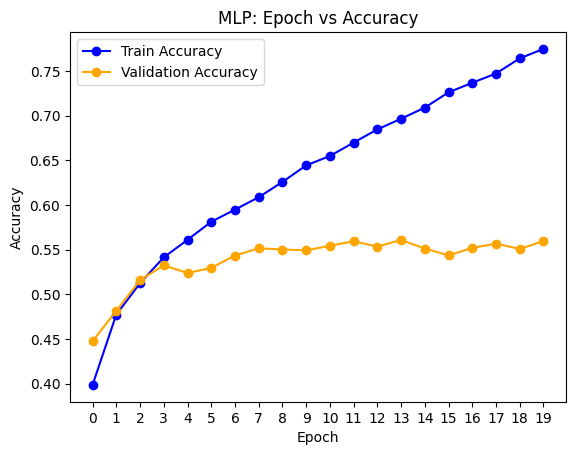

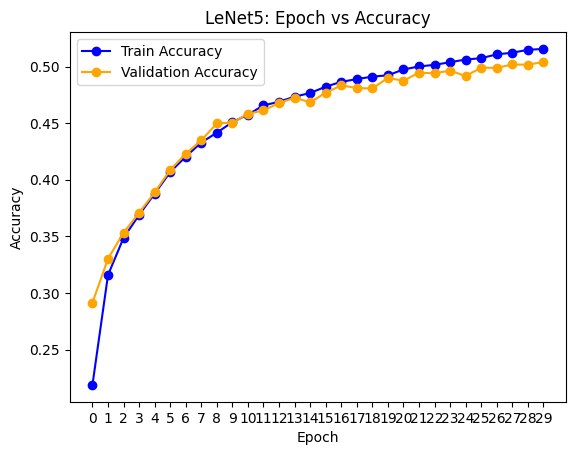

In [95]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

plot_losses(mlp_train_accs, mlp_val_accs, 20, loss=False, network_name="MLP")
plot_losses(lenet5_train_accs, lenet5_val_accs, 30, loss=False, network_name="LeNet5")

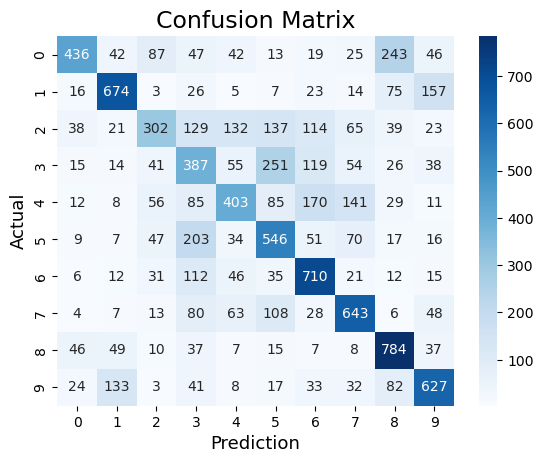

              precision    recall  f1-score   support

           0       0.72      0.44      0.54      1000
           1       0.70      0.67      0.69      1000
           2       0.51      0.30      0.38      1000
           3       0.34      0.39      0.36      1000
           4       0.51      0.40      0.45      1000
           5       0.45      0.55      0.49      1000
           6       0.56      0.71      0.62      1000
           7       0.60      0.64      0.62      1000
           8       0.60      0.78      0.68      1000
           9       0.62      0.63      0.62      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.55     10000
weighted avg       0.56      0.55      0.55     10000



In [22]:
## TODO: Plot the confusion matrix for LeNet5
calc_confusion_values(test_loader, network, device)

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in performance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
